In [1]:
import math
import random
import yaml
import argparse
from dotmap import DotMap

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn.functional import cosine_similarity

import matplotlib.pyplot as plt
import wandb

In [2]:
import sys
sys.path.append("./src")  # make sure Python can find src/
from model_linear import GPTLinear
from model_softmax import GPTSoftmax
from data import MovingWindowSum

In [3]:
%load_ext autoreload
%autoreload 2


### Defined MWS without a mod function to it to see effect

In [3]:
# Data

class MovingWindowSumNoSep:
    def __init__(self, min_num=1, max_num=16, k=2, p=17, sep=17, device="cuda"):
        self.min_num = min_num
        self.max_num = max_num
        self.k = k
        self.p = p
        self.sep = sep
        self.device = device
        assert self.p > self.max_num

    @torch.no_grad()
    def sample(
        self,
        num_samples,
        num_tokens,
    ):
        random_ints = torch.randint(
            low=self.min_num, high=self.max_num + 1, size=(num_samples, num_tokens)
        ).to(self.device)

        random_ints_np = random_ints.detach().cpu().numpy()
        convolution = torch.stack(
            [
                torch.from_numpy(
                    np.convolve(
                        random_ints_np[i],
                        np.ones(self.k),
                        mode="valid",
                    )
                )
                for i in range(random_ints.shape[0])
            ]
        )

        moving_sum = random_ints.clone().detach()
        moving_sum[:, self.k - 1 :] = convolution

        # for i in range(num_samples):
        #     for j in range(0, self.k - 1):
        #         if moving_sum[i, j] != random_ints[i, j]:
        #             print(f"ERROR! {i} {j}")
        #     for j in range(self.k - 1, num_tokens):
        #         if moving_sum[i, j] != torch.sum(random_ints[i, j-self.k+1:j+1]):
        #             print(f"ERROR! {i} {j}")

        # exit()
        samples = (
            torch.cat(
                [
                    random_ints,
                    # self.sep * torch.ones(size=(num_samples, 1)).to(self.device),
                    torch.remainder(input=moving_sum, other=self.p),
                ],
                axis=-1,
            )
            .to(int)
            .detach()
        )

        return samples

In [4]:
# Train
def train_step(
    model,
    optim,
    data_sampler,
    step,
    config,
):
    n_train, n_test, num_tokens = (
        config.data.n_train,
        config.data.n_test,
        config.data.num_tokens,
    )

    data = data_sampler.sample(
        num_samples=n_train + n_test,
        num_tokens=num_tokens,
    )

    train_data = data[:n_train, :]
    test_data = data[n_train:, :]

    prompt_len = num_tokens# + 1
    gen_len = num_tokens
    acc_start = num_tokens# + 1

    model.train()
    optim.zero_grad(set_to_none=True)

    _, _, _, loss = model(
        train_data[:, :-1], prompt_len = prompt_len, targets=train_data[:, 1:]
    )
    loss.backward()

    if config.train.grad_clip > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.train.grad_clip)

    optim.step()

    model.eval()
    with torch.no_grad():
        # Log train loss, train / test acc, repetition frequency
        attn_map, pre_lm_h, _, train_loss = model(train_data[:, :-1], targets=train_data[:, 1:], prompt_len=prompt_len)

        train_pred = model.generate(
            idx=train_data[:, :prompt_len],
            max_new_tokens=gen_len,
            prompt_len = prompt_len
        )
        test_pred = model.generate(
            idx=test_data[:, :prompt_len],
            max_new_tokens=gen_len,
            prompt_len = prompt_len,
        )

        train_acc = torch.mean(
            (train_pred[:, acc_start:] == train_data[:, acc_start:]).to(float)
        ).item()
        test_acc = torch.mean(
            (test_pred[:, acc_start:] == test_data[:, acc_start:]).to(float)
        ).item()

        data_repeat_frac = torch.mean((test_data[:, acc_start:-1] == test_data[:, acc_start+1:]).to(float))
        model_repeat_frac = torch.mean((test_pred[:, acc_start:-1] == test_pred[:, acc_start+1:]).to(float))

        # Log attention progress measure
        attn_map_output_seq = attn_map[:, :, acc_start-1:]
        att_mask = torch.zeros_like(attn_map_output_seq).to(device)

        att_mask[:, :, 0, 0] = 1
        for i in range(num_tokens - 1):
            att_mask[:, :, i + 1, i : i + 2] = 1

        att_prog_measure = torch.mean(
            torch.sum(torch.abs(attn_map_output_seq) * att_mask, dim=(-3, -2, -1)) /
            torch.sum(torch.abs(attn_map_output_seq), dim=(-3, -2, -1)),
            dim=0
        )

        # Log pair-wise cosine similarity between hidden states
        embed_start = acc_start - 1
        embed_len = gen_len

        logit_cs = torch.zeros((embed_len, embed_len))

        for i_1 in range(embed_start, embed_start + embed_len):
            for i_2 in range(embed_start, i_1):
                logit_cs[i_1 - embed_start, i_2 - embed_start] = torch.mean(
                    (
                        cosine_similarity(
                            pre_lm_h[:, i_1, :], pre_lm_h[:, i_2, :], dim=-1
                        )
                    ), dim=0
                )

        # Log plots for cosine similarity, attention map
        logit_fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))

        im1 = ax[0].imshow(logit_cs)
        ax[0].set_title("avg pre_lm_h cosine sim")
        cb1 = logit_fig.colorbar(im1, location="right", shrink=0.99, pad=0.02, ax=ax[0])

        avg_attn_map = torch.mean(attn_map, dim=0).squeeze().detach().cpu().numpy()

        im2 = ax[1].imshow(avg_attn_map)
        ax[1].set_title("att map")
        cb4 = logit_fig.colorbar(im2, location="right", shrink=0.99, pad=0.02, ax=ax[1])
        ax[1].set_xticks(range(avg_attn_map.shape[-1]))
        ax[1].set_yticks(range(avg_attn_map.shape[-2]))

        for i1 in range(embed_len):
            for i2 in range(embed_len):
                text1 = ax[0].text(
                    i2,
                    i1,
                    round(logit_cs[i1, i2].item(), 2),
                    ha="center",
                    va="center",
                    color="w",
                )


        print(
            f"Step {step} -- Train loss: {train_loss}, Train Acc: {train_acc} Test Acc: {test_acc}"
        )
        # print(f"input: {test_data[0]} \n predicted:{test_pred[0]}")

        if config.train.wandb:

            log_data = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "data_repeat_frac": data_repeat_frac,
                "model_repeat_frac": model_repeat_frac,
                "att_prog_measure": att_prog_measure,
                "pre_lm_h_cosine_sim": logit_fig,
                "mean_cosine_sim": torch.sum(logit_cs[:, 1:]) / (0.5 * (gen_len-1) * (gen_len-2))
            }

            for output_pos in range(gen_len):
                log_data.update(
                    {
                        f"idx{output_pos}_check": torch.mean(
                            (train_pred[:, acc_start + output_pos] == train_data[:, acc_start + output_pos]).to(float)
                        ).item()
                    }
                )

                if output_pos < gen_len-1:
                    log_data.update(
                        {
                            f"mean_cosine_sim_{output_pos}": torch.sum(logit_cs[:, output_pos]) / (gen_len-1-output_pos)
                        }
                    )

            wandb.log(log_data)

        plt.close()
        del (
            logit_fig,
            ax,
            logit_cs,
        )

        if config.train.save_ckpt:
            if (step == 0) or ((step + 1) % config.train.ckpt_freq == 0):
                model.train()
                torch.save(
                    {
                        "epoch": step,
                        "model": model.state_dict(),
                        "optim": optim.state_dict(),
                        "train_loss": train_loss,
                        "test_acc": test_acc,
                    },
                    "./mws_k2_l1_h1_a16_n16.tar",
                )
                print(f"saved state at epoch {step} to {f'./mws_k2_l1_h1_a16_n16.tar'}")

                if config.train.wandb:
                    model_wandb = wandb.Artifact(
                        f"model_step{step}", type="model"
                    )
                    model_wandb.add_file(f"./mws_k2_l1_h1_a16_n16.tar")
                    wandb.log_artifact(model_wandb)
                    print("model uploaded to wandb")

In [5]:
# Config

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

config = {
'model':
  {
    'n_layer': 1,
    'n_head': 1,
    'n_embd': 256,
    'linear': True,
  },

'data':
  {
    'name': 'window',
    'min_num': 1,
    'max_num': 16,
    'k': 2,
    'p': 17,
    'sep': 17,
    'cot': False,
    'num_tokens': 16,
    'n_train': 256,
    'n_test': 64,
    'fixed_len': True,
  },

'train':
  {
    'lr': 0.0001,
    'grad_clip': -1,
    'num_steps': 500,
    'norm_type': "none_rank",
    'wandb': True,
    'save_ckpt': False,
    'ckpt_freq': 20,
  }
}

/home/jyue/.conda/envs/emerge/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jetyue04 (wth_ucsd). Use `wandb login --relogin` to force relogin


Step 0 -- Train loss: 2.8827478885650635, Train Acc: 0.061279296875 Test Acc: 0.0615234375
Step 1 -- Train loss: 2.8880960941314697, Train Acc: 0.069091796875 Test Acc: 0.0654296875
Step 2 -- Train loss: 2.8756167888641357, Train Acc: 0.064697265625 Test Acc: 0.0615234375
Step 3 -- Train loss: 2.8664612770080566, Train Acc: 0.0576171875 Test Acc: 0.05078125
Step 4 -- Train loss: 2.8565330505371094, Train Acc: 0.06005859375 Test Acc: 0.064453125
Step 5 -- Train loss: 2.8554422855377197, Train Acc: 0.06298828125 Test Acc: 0.0458984375
Step 6 -- Train loss: 2.854156494140625, Train Acc: 0.060546875 Test Acc: 0.0712890625
Step 7 -- Train loss: 2.84824538230896, Train Acc: 0.064208984375 Test Acc: 0.0556640625
Step 8 -- Train loss: 2.848928928375244, Train Acc: 0.059326171875 Test Acc: 0.060546875
Step 9 -- Train loss: 2.8471641540527344, Train Acc: 0.06201171875 Test Acc: 0.0576171875
Step 10 -- Train loss: 2.8429408073425293, Train Acc: 0.056396484375 Test Acc: 0.0556640625
Step 11 -- Tra

KeyboardInterrupt: 

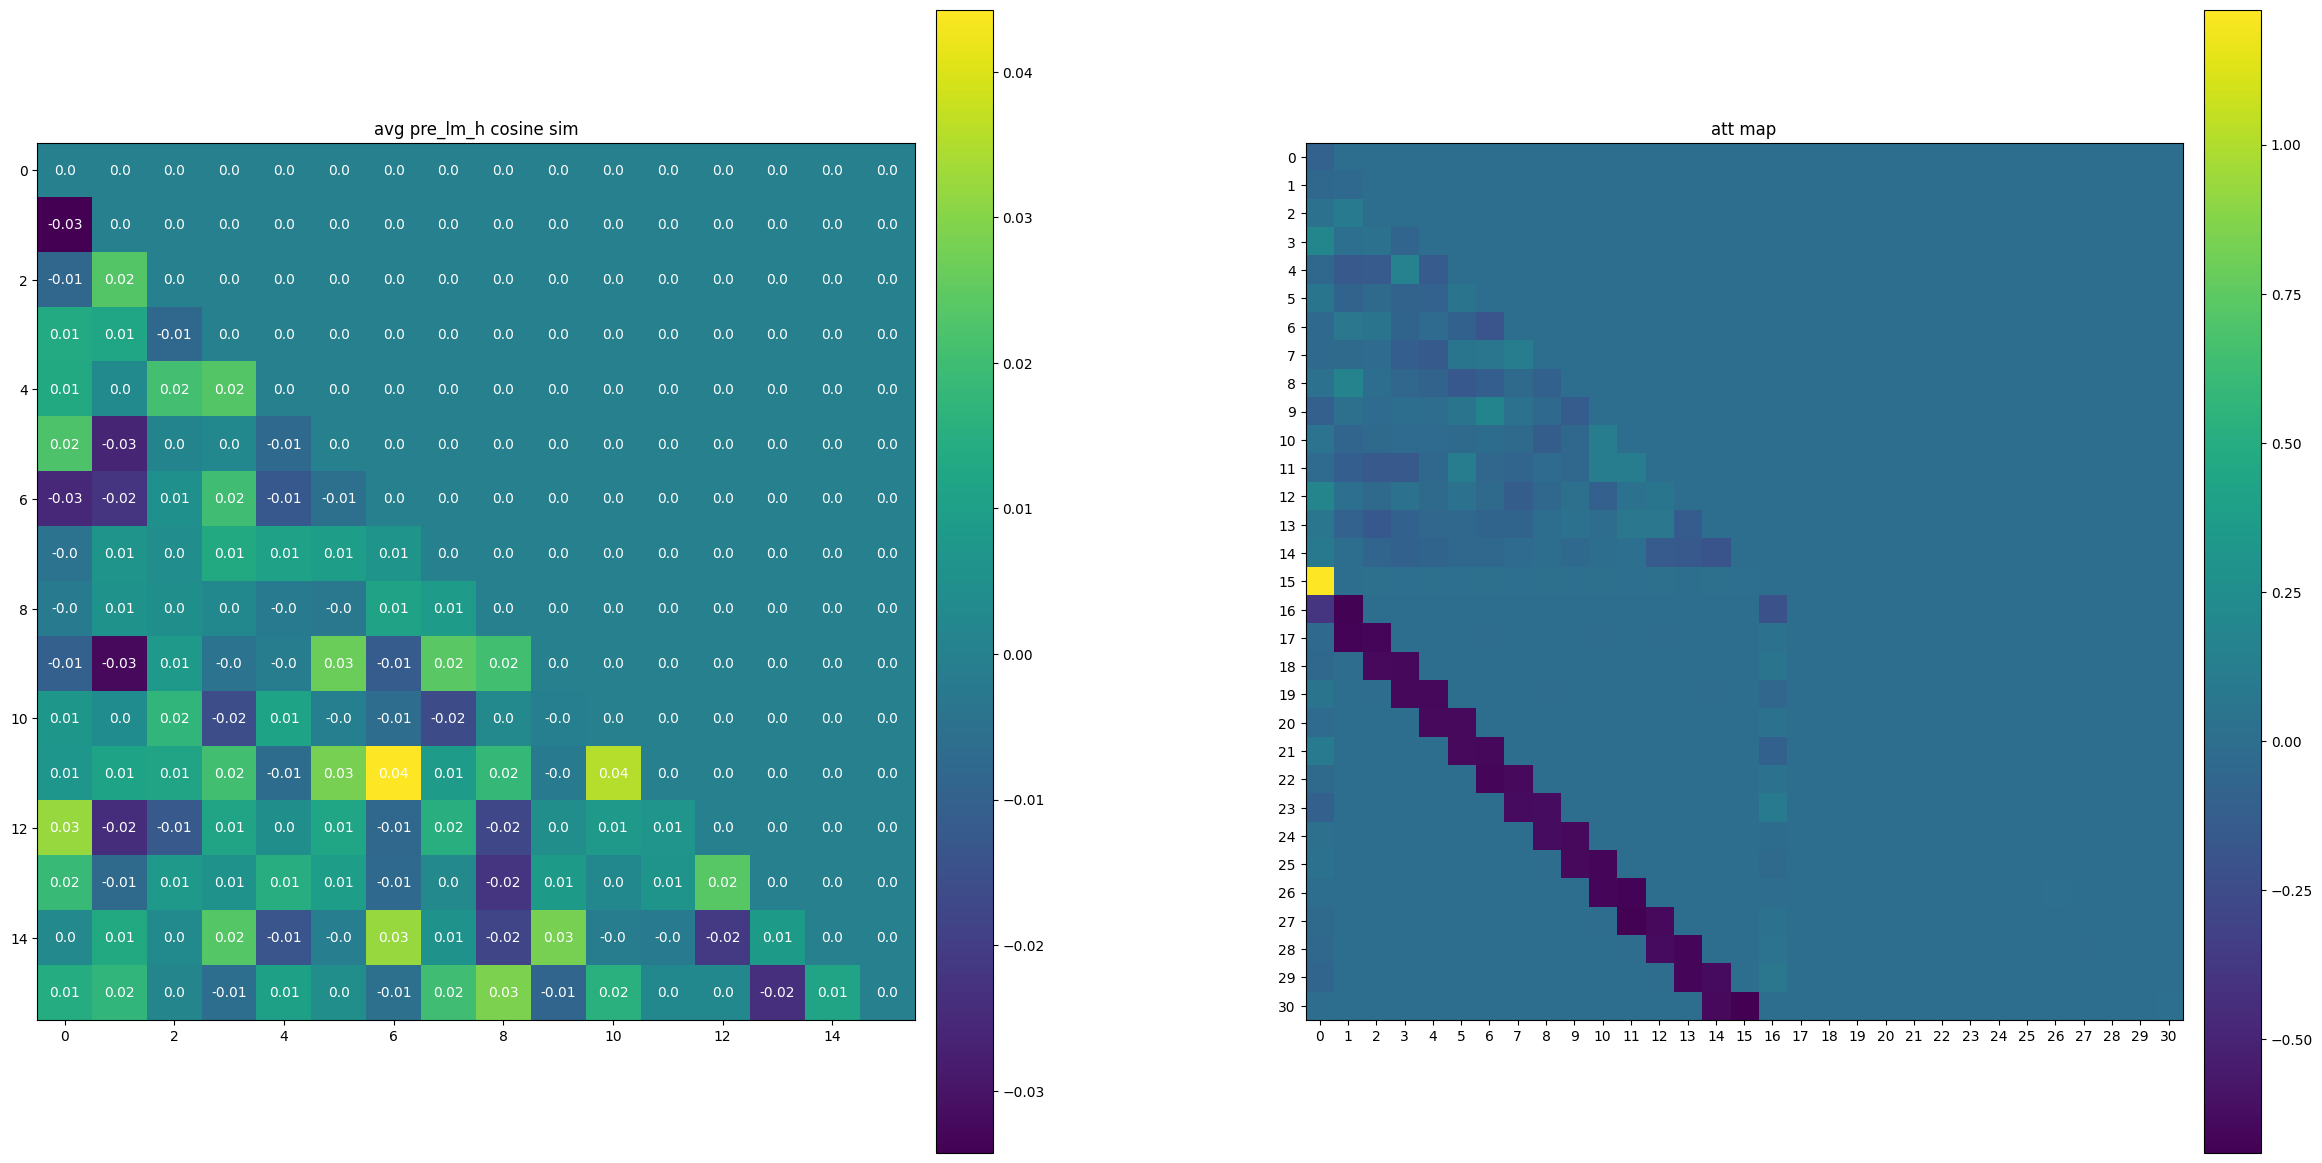

In [7]:
config = DotMap(config)

config.model.vocab_size = max(config.data.p, config.data.max_num) + 1
config.model.block_size = 2 * config.data.num_tokens

data_sampler = MovingWindowSumNoSep(
    min_num=config.data.min_num,
    max_num=config.data.max_num,
    k=config.data.k,
    p=config.data.p,
    device=device
)

model = GPTLinear(config.model, return_att=True).to(device)
optim = Adam(model.parameters(), lr=config.train.lr)

if config.train.wandb:
    wandb_run_name = 'mws_linear_attention_loss_noinput_test2'
    wandb.login(key="")
    wandb.init(project="loss_plateau_tf", name=wandb_run_name, config=config)
    wandb.watch(model)

for step in range(config.train.num_steps):
    train_step(
        model=model,
        optim=optim,
        data_sampler=data_sampler,
        step=step,
        config=config,
    )

if config.train.wandb:
    wandb.finish()

In [9]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


att_prog_measure,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▅▅▆▆▆▇▇▇▇█████████████
data_repeat_frac,▅▆▆▄▅▅▄▇▇▄▂▃▇▃▅▅▇▃▅▅▃▆▅▅▅▅▇▆▄▂▇▆▆▃▅▇▁▄█▂
idx0_check,▁▁▁▁▂▃▄▇▇███████████████████████████████
idx10_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▆█████████████████
idx11_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▇█████████████████
idx12_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▆█████████████████
idx13_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▇█████████████████
idx14_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▆█████████████████
idx15_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▆█████████████████
idx1_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▅▇█████████████████
idx2_check,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▇█████████████████


In [8]:
config = DotMap(config)

config.model.vocab_size = max(config.data.p, config.data.max_num) + 1
config.model.block_size = 2 * config.data.num_tokens # + 1

data_sampler = MovingWindowSumNoSep(
    min_num=config.data.min_num,
    max_num=config.data.max_num,
    k=config.data.k,
    p=config.data.p,
    device=device
)

model = GPTSoftmax(config.model, return_att=True).to(device)
optim = Adam(model.parameters(), lr=config.train.lr)

if config.train.wandb:
    wandb_run_name = 'mws_softmax_attention_loss_noinput_test3'
    wandb.login(key="")
    wandb.init(project="loss_plateau_tf", name=wandb_run_name, config=config)
    wandb.watch(model)

for step in range(config.train.num_steps):
    train_step(
        model=model,
        optim=optim,
        data_sampler=data_sampler,
        step=step,
        config=config,
    )

if config.train.wandb:
    wandb.finish()

Step 0 -- Train loss: 2.883361339569092, Train Acc: 0.065673828125 Test Acc: 0.05078125
Step 1 -- Train loss: 2.8664538860321045, Train Acc: 0.064697265625 Test Acc: 0.0556640625
Step 2 -- Train loss: 2.856760025024414, Train Acc: 0.06494140625 Test Acc: 0.0546875
Step 3 -- Train loss: 2.8551018238067627, Train Acc: 0.06396484375 Test Acc: 0.0576171875
Step 4 -- Train loss: 2.843663454055786, Train Acc: 0.057861328125 Test Acc: 0.0419921875
Step 5 -- Train loss: 2.8419857025146484, Train Acc: 0.06591796875 Test Acc: 0.05859375
Step 6 -- Train loss: 2.844399929046631, Train Acc: 0.066162109375 Test Acc: 0.060546875
Step 7 -- Train loss: 2.8436179161071777, Train Acc: 0.062255859375 Test Acc: 0.0576171875
Step 8 -- Train loss: 2.839456081390381, Train Acc: 0.062255859375 Test Acc: 0.0703125
Step 9 -- Train loss: 2.8368782997131348, Train Acc: 0.062255859375 Test Acc: 0.07421875
Step 10 -- Train loss: 2.8378257751464844, Train Acc: 0.0615234375 Test Acc: 0.0478515625
Step 11 -- Train loss

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


att_prog_measure,▁▁▁▁▁▁▁▁▂▂▃▅▇▇██████████████████████████
data_repeat_frac,▃▄▄▂▇▄▁▄▃▄▅▆▄▄▄▄▅▆▅▄▄▃▃▄▄▄▅▅▆▆▄▆▄▅▂▄█▆▃▄
idx0_check,▂▃▃▃▁▄▂▃▄▂█▅▅▃▄▂▂▄▅▃▅▃▄▃▆▂▅▄▆▁▅▃▄▆▄█▆▅▅▃
idx10_check,▁▁▁▁▁▁▁▁▁▁▂▃▇███████████████████████████
idx11_check,▁▁▁▁▁▁▁▁▁▁▁▂████████████████████████████
idx12_check,▁▁▁▁▁▁▁▁▁▁▁▂▇███████████████████████████
idx13_check,▁▁▁▁▁▁▁▁▁▁▁▂████████████████████████████
idx14_check,▁▁▁▁▁▁▁▁▁▁▁▂▇███████████████████████████
idx15_check,▁▁▁▁▁▁▁▁▁▁▁▂████████████████████████████
idx1_check,▁▁▁▁▁▁▁▁▁▁▂▃▇███████████████████████████
idx2_check,▁▁▁▁▁▁▁▁▁▂▁▃▇███████████████████████████
